In [18]:
import pandas as pd
import numpy as np
import random
from scipy import stats
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def gaussian_mech(v, sensitivity, epsilon, delta):
    return v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)

def gaussian_mech_vec(vec, sensitivity, epsilon, delta):
    return [v + np.random.normal(loc=0, scale=sensitivity * np.sqrt(2*np.log(1.25/delta)) / epsilon)
            for v in vec]

def pct_error(orig, priv):
    return float(np.abs(orig - priv)/orig * 100.0)

compas = pd.read_csv('cox-violent-parsed.csv')
adult = pd.read_csv('adult_with_pii.csv')

# this code adds id values for all of the data rows past row 11000
for i in range(11001, len(compas)):
    compas.iloc[i, 0] = i+1

In [19]:
compas # id column only increments up to 11001 without the fix (technically the 11000th row, starting at 0)

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
0,1.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,0,327,0
1,2.0,miguel hernandez,miguel,hernandez,14/08/2013,Male,18/04/1947,69,Greater than 45,Other,...,Risk of Violence,1,Low,14/08/2013,07/07/2014,14/07/2014,0,334,961,0
2,3.0,michael ryan,michael,ryan,31/12/2014,Male,06/02/1985,31,25 - 45,Caucasian,...,Risk of Violence,2,Low,31/12/2014,30/12/2014,03/01/2015,0,3,457,0
3,4.0,kevon dixon,kevon,dixon,27/01/2013,Male,22/01/1982,34,25 - 45,African-American,...,Risk of Violence,1,Low,27/01/2013,26/01/2013,05/02/2013,0,9,159,1
4,5.0,ed philo,ed,philo,14/04/2013,Male,14/05/1991,24,Less than 25,African-American,...,Risk of Violence,3,Low,14/04/2013,16/06/2013,16/06/2013,4,0,63,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18311,18312.0,alexsandra beauchamps,alexsandra,beauchamps,29/12/2014,Female,21/12/1984,31,25 - 45,African-American,...,Risk of Violence,4,Low,29/12/2014,28/12/2014,07/01/2015,5,9,459,0
18312,18313.0,winston gregory,winston,gregory,14/01/2014,Male,01/10/1958,57,Greater than 45,Other,...,Risk of Violence,1,Low,14/01/2014,13/01/2014,14/01/2014,0,0,808,0
18313,18314.0,farrah jean,farrah,jean,09/03/2014,Female,17/11/1982,33,25 - 45,African-American,...,Risk of Violence,2,Low,09/03/2014,08/03/2014,09/03/2014,3,0,754,0
18314,18315.0,florencia sanmartin,florencia,sanmartin,30/06/2014,Female,18/12/1992,23,Less than 25,Hispanic,...,Risk of Violence,4,Low,30/06/2014,15/03/2015,15/03/2015,2,0,258,0


In [20]:
compas[compas['id'] == 11001]

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
11000,11001.0,david picard,david,picard,30/09/2013,Male,19/03/1987,29,25 - 45,Caucasian,...,Risk of Violence,6,Medium,30/09/2013,12/06/2014,15/07/2014,1,251,255,0


In [21]:
compas[compas['id'] == 11002]

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_type_of_assessment,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event
11001,11002.0,david picard,david,picard,30/09/2013,Male,19/03/1987,29,25 - 45,Caucasian,...,Risk of Violence,6,Medium,30/09/2013,19/08/2015,21/09/2015,1,288,688,0


### Actual Data

First, let's examine the COMPAS dataset without any noise to establish a baseline:

In [22]:
# decile_score includes ALL of the recorded risk scores
# v_decile_score is just violent risk scores
compas.columns

Index(['id', 'name', 'first', 'last', 'compas_screening_date', 'sex', 'dob',
       'age', 'age_cat', 'race', 'juv_fel_count', 'decile_score',
       'juv_misd_count', 'juv_other_count', 'priors_count',
       'days_b_screening_arrest', 'c_jail_in', 'c_jail_out', 'c_case_number',
       'c_offense_date', 'c_arrest_date', 'c_days_from_compas',
       'c_charge_degree', 'c_charge_desc', 'is_recid', 'r_case_number',
       'r_charge_degree', 'r_days_from_arrest', 'r_offense_date',
       'r_charge_desc', 'r_jail_in', 'r_jail_out', 'violent_recid',
       'is_violent_recid', 'vr_case_number', 'vr_charge_degree',
       'vr_offense_date', 'vr_charge_desc', 'type_of_assessment',
       'decile_score.1', 'score_text', 'screening_date',
       'v_type_of_assessment', 'v_decile_score', 'v_score_text',
       'v_screening_date', 'in_custody', 'out_custody', 'priors_count.1',
       'start', 'end', 'event'],
      dtype='object')

(array([  23., 2923., 2031., 1813., 1830., 1649., 1713., 1720., 1614.,
        3000.]),
 array([-1. ,  0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ]),
 <BarContainer object of 10 artists>)

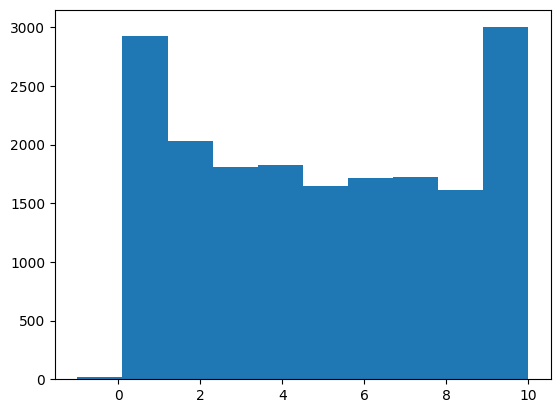

In [23]:
plt.hist(compas['decile_score'], bins=10)

(array([   6., 4118., 2536., 2467., 2026., 1864., 1615., 1307.,  994.,
        1383.]),
 array([-1. ,  0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ]),
 <BarContainer object of 10 artists>)

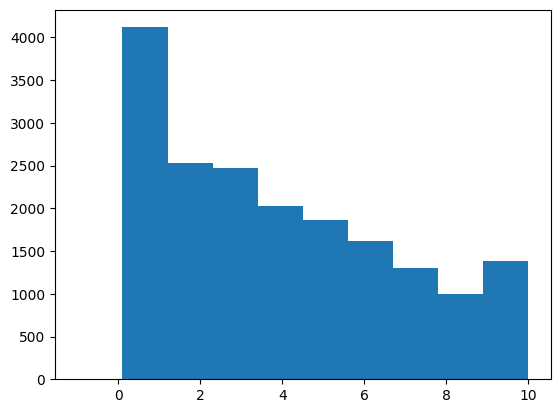

In [24]:
plt.hist(compas['v_decile_score'], bins=10)

We can then choose some other columns within the data, with the idea being that we can find out if there are any correlations between the chosen columns and the final score results, as well as check the accuracy of the counts in our synthetic representation/data.

In [25]:
columns_to_use = ['sex', 'race', 'age', 'c_charge_desc', 'priors_count']

### Synthetic Representation
Creating a synthetic representation used to create synthetic data for testing

In [26]:
# Getting a synthetic representation of the overall decile_score data
def noisy_score_hist(epsilon):
    hist = compas['decile_score'].value_counts()
    # Sensitivity = 1 because histograms are counting queries
    # Parallel composition applies because it is a histogram
    return hist.apply(lambda x: laplace_mech(x, 1, epsilon))

(array([  23., 2923., 2031., 1813., 1830., 1649., 1713., 1720., 1614.,
        3000.]),
 array([-1. ,  0.1,  1.2,  2.3,  3.4,  4.5,  5.6,  6.7,  7.8,  8.9, 10. ]),
 <BarContainer object of 10 artists>)

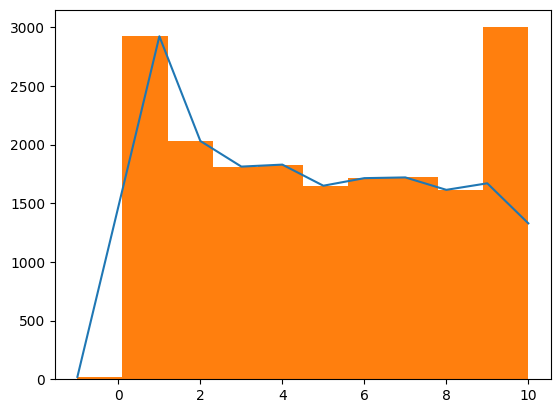

In [27]:
# Line representing synthetic rep.
plt.plot(noisy_score_hist(1.0).sort_index());
# Actual data
plt.hist(compas['decile_score'], bins=10)

In [28]:
# Create a one-way marginal based on any column in the compas dataset
def dp_one_way_marginal(col, epsilon):
    hist = compas[col].value_counts()
    hist = hist.apply(lambda x: laplace_mech(x, 1, epsilon))
    
    syn_rep = hist
    syn_rep_nonzero = syn_rep.clip(lower=0)
    syn_normalized = syn_rep_nonzero / syn_rep_nonzero.sum()
    return syn_normalized #.to_frame(name='probability').reset_index()

In [29]:
dp_one_way_marginal('decile_score', 1.0).to_frame().reset_index()

,decile_score,count
0,1,0.159680
1,2,0.110817
2,4,0.099911
3,3,0.099014
4,7,0.093916
5,6,0.093402
6,9,0.091227
7,5,0.090057
8,8,0.088109
9,10,0.072628


In [30]:
dp_one_way_marginal('v_decile_score', 1.0).to_frame().reset_index()

,v_decile_score,count
0,1,0.224794
1,2,0.138472
2,3,0.134744
3,4,0.110553
4,5,0.101688
5,6,0.088200
6,7,0.071414
7,8,0.054313
8,9,0.051760
9,10,0.023720


#### Testing
- Take these marginals and create synthetic data and compare it to the original COMPAS data (random subset of COMPAS that is the same size as the synthetic data)
- Also create marginals for the adult dataset and compare their synthetic data with the original adult data
- Examine the difference between the synthetic data and the actual data for both datasets to determine the accuracy of the method
- Repeat above with higher dimensional marginals

In [31]:
# Create synthetic data 
def gen_samples(n, marginal):
    return marginal.sample(n=n, replace=True, weights='probability', axis=0)
    
def dp_synthetic_data(cols, n, epsilon):
    syn_data = pd.DataFrame()
    col_count = 0
    for c in cols:
        marginal = dp_one_way_marginal(c, epsilon/len(cols))
        marginal = marginal.to_frame(name='probability').reset_index()
        temp_df = pd.DataFrame(gen_samples(n, marginal), columns=[c]).reset_index()
        syn_data.insert(loc=col_count, column=c, value=temp_df[c].values.tolist())
        col_count += 1
    return syn_data
    
# all_columns = columns_to_use + ['decile_score', 'v_decile_score']
# syn_data = dp_synthetic_data(all_columns, 10, 1.0)
syn_data = dp_synthetic_data(['decile_score', 'v_decile_score'], len(compas), epsilon=1.0)
syn_data

,decile_score,v_decile_score
0,10,1
1,4,1
2,5,5
3,6,7
4,9,5
...,...,...
18311,6,3
18312,6,1
18313,2,5
18314,9,8


In [32]:
# Pull random sample data from the COMPAS dataset
# random_subset = [random.randrange(0, 18316) for x in range(100)]
# real_vals = compas.iloc[random_subset]
real_vals_decile = compas['decile_score']
real_vals_decile

0        1
1        1
2        5
3        3
4        4
        ..
18311    6
18312    1
18313    2
18314    4
18315    4
Name: decile_score, Length: 18316, dtype: int64

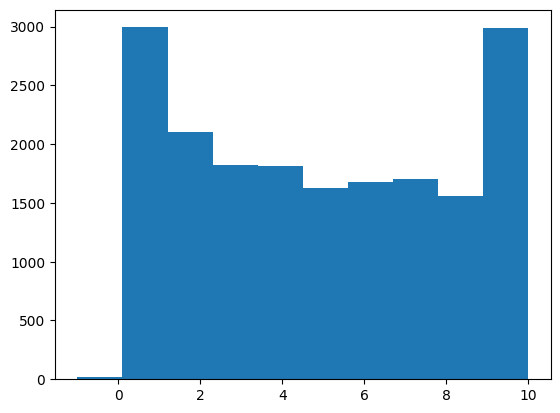

In [33]:
# Compare syn_data hist to real_data hist
plt.hist(syn_data['decile_score'])
# plt.hist(real_vals_decile, alpha=0.3)
plt.show()

In [34]:
# Find how accurate the synthetic data is to the random subset
# Use percent error

syn_decile_score_counts = syn_data['decile_score'].value_counts().to_dict()
real_decile_score_counts = real_vals_decile.value_counts().to_dict()

# syn_decile_score_counts = sorted(syn_decile_score_counts.items())
# print(dict(sorted(syn_decile_score_counts.items())))
syn_decile_score_counts = dict(sorted(syn_decile_score_counts.items()))
# print(syn_decile_score_counts[0][1])
# print(dict(sorted(real_decile_score_counts.items())))
real_decile_score_counts = dict(sorted(real_decile_score_counts.items()))

# store the difference values for each column
difference_vals = [real-syn for syn,real in zip(syn_decile_score_counts.values(),real_decile_score_counts.values())]
# print(difference_vals)

percent_err_per_col = [pct_error(real,syn) for syn,real in zip(syn_decile_score_counts.values(),real_decile_score_counts.values())]
print(pd.DataFrame(percent_err_per_col, columns={'Percent Error':1}))

    Percent Error
0       13.043478
1        2.429011
2        3.594289
3        0.441258
4        0.819672
5        1.091571
6        2.101576
7        0.930233
8        3.469641
9        0.778443
10       1.578947


In [35]:
# Create two-way marginal between race and decile score
def dp_two_marginal(col1, col2, epsilon):
    hist = compas[[col1, col2]].value_counts()
    hist = hist.apply(lambda x: laplace_mech(x, 1, epsilon))

    syn_rep = hist
    syn_rep_nonzero = syn_rep.clip(lower=0)
    syn_normalized = syn_rep_nonzero / syn_rep_nonzero.sum()
    syn_normalized = syn_normalized.to_frame().reset_index()
    return syn_normalized.rename(columns={'count':'probability'})

syn_rep_race = dp_two_marginal('race', 'decile_score', 1.0)

In [36]:
def gen_conditional(col, col2, m1_val, m2):
    conditioned_dist = m2[m2[col]==m1_val]
    return conditioned_dist.sample(n=1, weights='probability')[col2].iloc[0]
    
def dp_synthetic_data_two_marginal(n, epsilon):
    # Race & Decile Score 2-way
    # Generate 1-way marginal for race
    m1 = dp_one_way_marginal('race', epsilon/2)
    m1 = m1.to_frame(name='probability').reset_index()
    
    # Generate 2-way marginal for race, decile_score
    m2 = dp_two_marginal('race', 'decile_score', epsilon/2)

    # Create race sampling
    race_sampled = m1.sample(n=n, replace=True, weights='probability')[['race']]
    
    race_decile = race_sampled
    # Generate occupations conditioned on race using gen_conditional
    race_decile['decile_score'] = [gen_conditional('race', 'decile_score', race, m2) for race in race_decile['race']]

    return race_decile
    
syn_data_race = dp_synthetic_data_two_marginal(len(compas), 1.0)

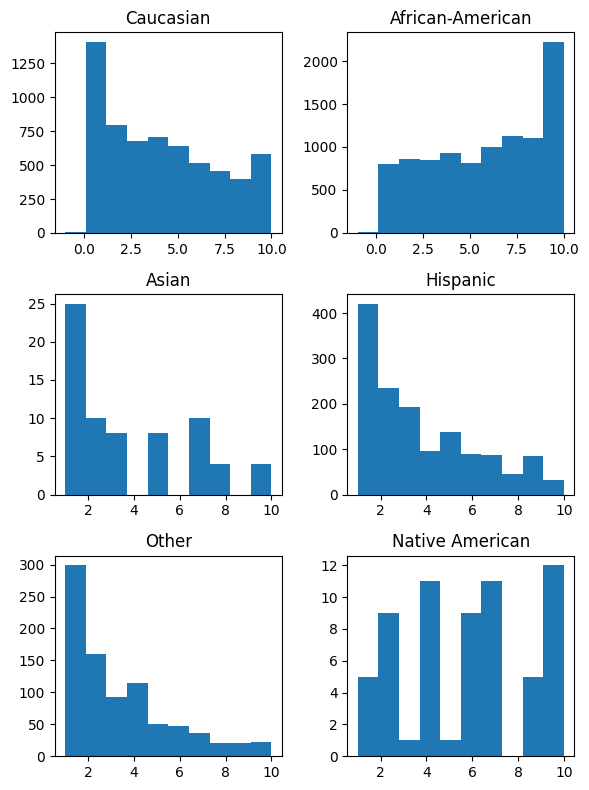

In [37]:
# Create plots for each race and their decile scores

races = syn_data_race['race'].unique()
fig, ((ax0, ax1), (ax2, ax3), (ax4, ax5)) = plt.subplots(nrows=3, ncols=2, figsize=(6, 8))

ax0.hist(syn_data_race[syn_data_race['race'] == races[0]]['decile_score'], 10)
# ax0.hist(compas[compas['race'] == races[0]]['decile_score'], 10, alpha=0.3)
ax0.set_title(races[0])

ax1.hist(syn_data_race[syn_data_race['race'] == races[1]]['decile_score'], 10)
# ax1.hist(compas[compas['race'] == races[1]]['decile_score'], 10, alpha=0.3)
ax1.set_title(races[1])

ax2.hist(syn_data_race[syn_data_race['race'] == races[2]]['decile_score'], 10)
# ax2.hist(compas[compas['race'] == races[2]]['decile_score'], 10, alpha=0.3)
ax2.set_title(races[2])

ax3.hist(syn_data_race[syn_data_race['race'] == races[3]]['decile_score'], 10)
# ax3.hist(compas[compas['race'] == races[3]]['decile_score'], 10, alpha=0.3)
ax3.set_title(races[3])

ax4.hist(syn_data_race[syn_data_race['race'] == races[4]]['decile_score'], 10)
# ax4.hist(compas[compas['race'] == races[4]]['decile_score'], 10, alpha=0.3)
ax4.set_title(races[4])

ax5.hist(syn_data_race[syn_data_race['race'] == races[5]]['decile_score'], 10)
# ax5.hist(compas[compas['race'] == races[5]]['decile_score'], 10, alpha=0.3)
ax5.set_title(races[5])

fig.tight_layout()
plt.show()

Focusing in on the African-American and Caucasian decile scores, we see that in our synthetic data that African-American defendants tend to have decile scores that are larger overall, while Caucasian decile scores tend to trend downwards.

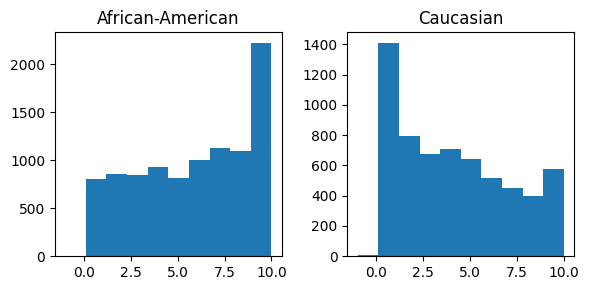

In [45]:
fig, ((ax0, ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))

ax0.hist(syn_data_race[syn_data_race['race'] == 'African-American']['decile_score'], 10)
# ax0.hist(compas[compas['race'] == races[0]]['decile_score'], 10, alpha=0.3)
ax0.set_title('African-American')

ax1.hist(syn_data_race[syn_data_race['race'] == 'Caucasian']['decile_score'], 10)
# ax1.hist(compas[compas['race'] == races[1]]['decile_score'], 10, alpha=0.3)
ax1.set_title('Caucasian')

fig.tight_layout()
plt.show()